# Vladiana cyclone pressure as seen on the native triangular grid and an interpolated r1x1 grid

The interpolated data was obtained by cdo remapcon.

The cyclone pressure on the native grid shows some small-scale "noisy behavior" for some of the simulations. It appears this behavior only occurs for the simulations with 2-moment microphyiscs. As a result, the simple minimum search of the MSLP field can fail and the diagnosed cyclone pressure can show zig-zags and kinks. I experimented with several ways to filter out these kinks, including to filter for extreme values of the time tendency of the cyclone pressure, and ideas to search for the native cyclone pressure only in a 1.5x1.5 deg region defined by the location of the cyclone found on the native grid. Yet, these approaches were not successful, and so I settled for an approach in which I manually filter out time steps with kinks, and linearly interpolate in between.

Also note that we do not consider the 2.5km simulations with only shallow convection scheme, as for these we do not have Lagrangian trajectories calculated by Anubhav Choudhary.

## Load python infrastructure

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43784 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 134.22 GB


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load ICON MSLP data

Also import the simulation dictionary and the plot color dictionary.

In [4]:
import sys
sys.path.append('/pf/b/b380459/nawdex-hackathon/shared')
import dict_nawdexsims

simdict   = dict_nawdexsims.simdictionary()
colordict = dict_nawdexsims.colordictionary()

Note that we only load data between 2016-09-22T12:00 and 2016-09-24T11:00, as this is the time period in which cyclone Vladiana intensified.

In [5]:
def load_mslp_native(sim):
    path  = '/scratch/b/b380459/icon_4_hackathon/'
        
    # grid 
    dict_gridres = {'80km': 'R80000m', '40km': 'R40000m', '20km': 'R20000m',
                    '10km': 'R10000m', '5km': 'R5000m', '2km': 'R2500m'}
    gridres = simdict[sim]['res']
    fname   = path+'/grids/icon-grid_nawdex_78w40e23n80n_'+dict_gridres[gridres]+'.nc'
    ds_grid = xr.open_dataset(fname)[['cell_area','clat', 'clon']].rename({'cell': 'ncells'})
    
    fname   = path+'/'+sim+'/'+sim+'_2016*_2d_30min_DOM01_ML_0*.nc'
    ds_mslp = ( xr.open_mfdataset(fname, combine='by_coords',parallel=True, 
                                  engine='h5netcdf', chunks={'time': 1})['pres_msl'].
                sel(time=slice('2016-09-22T12:00', '2016-09-24T11:00')))
    
    # merge and return dataset
    return xr.merge([ds_grid, ds_mslp])

def load_mslp_remap(sim):
    # because I want this to be a dataset, I am also loading tot_prec
    path  = '/work/bb1018/b380459/NAWDEX/ICON_OUTPUT_NWP/'
    fname   = path+'/'+sim+'/post/'+sim+'_2016*_2d_30min_alltimesteps.gridr1x1.nc'
    ds_mslp = ( xr.open_mfdataset(fname, engine='h5netcdf', chunks={'time': 1})[['pres_msl','tot_prec']].
                sel(time=slice('2016-09-22T12:00', '2016-09-24T11:00')))
    
    return ds_mslp

We only load Vladiana simulations (selected by the 'start' date). We also do not load
simulations at 2 km resolution with shallow convection scheme enabled.

In [6]:
ds_list_native = []
ds_list_remap  = []
for sim in list(simdict.keys()):
    if simdict[sim]['start']=='20160922' and simdict[sim]['conv']!=2: # and simdict[sim]['res']!='2km':
        print('Loading', sim)
        ds = load_mslp_native(sim); ds.attrs['sim'] = sim; ds_list_native.append(ds); del ds
        ds = load_mslp_remap(sim);  ds.attrs['sim'] = sim; ds_list_remap.append(ds);  del ds        

Loading nawdexnwp-80km-mis-0001
Loading nawdexnwp-80km-mis-0002
Loading nawdexnwp-40km-mis-0001
Loading nawdexnwp-40km-mis-0002
Loading nawdexnwp-20km-mis-0001
Loading nawdexnwp-20km-mis-0002
Loading nawdexnwp-10km-mis-0001
Loading nawdexnwp-10km-mis-0002
Loading nawdexnwp-10km-mis-0003
Loading nawdexnwp-10km-mis-0004


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Loading nawdexnwp-5km-mis-0001


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Loading nawdexnwp-5km-mis-0002


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Loading nawdexnwp-5km-mis-0003


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Loading nawdexnwp-5km-mis-0004


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Loading nawdexnwp-2km-mis-0001


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Loading nawdexnwp-2km-mis-0002


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Loading nawdexnwp-2km-mis-0003


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Loading nawdexnwp-2km-mis-0004


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


## Illustration of the "noisy" MSLP behavior on the example of the 40km simulation with 2-moment microphysics (nawdexnwp-40km-mis-0002)

* nawdexnwp-40km-mis-0002 has index 3 in ds_list_native
* time step 31 is a good example of the noisy behavior

Text(0, 0.5, 'latitude')

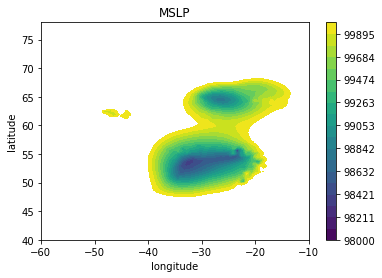

In [7]:
plt.tricontourf(180/np.pi*ds_list_native[3].clon, 180/np.pi*ds_list_native[3].clat, 
                ds_list_native[3].isel({'time':31})['pres_msl'], np.linspace(980e2,1000e2,20))
plt.colorbar()
plt.xlim(-60,-10); plt.ylim(40,78)
plt.title('MSLP'); plt.xlabel('longitude'); plt.ylabel('latitude')

## Find minimum of sea-level pressure

By restricting to latitudes south of ~60N we can circumvent to misidentify another cyclone to the north of Vladiana in the afternoon of Sep 22. I believe that cyclone was Ursula.

In [8]:
# total number of simulations
nsim = len(ds_list_native)

In [9]:
for i in range(nsim):
    ds = ds_list_native[i]
    ds = xr.where(np.rad2deg(ds.clat)>+60, 999e5, ds)
    # cyclone core pressure
    ds_list_native[i]['pres_msl_min'] = ds['pres_msl'].min('ncells').compute()
    # lat-lon location of cyclone, also save index of cell
    ind_cell = ds['pres_msl'].argmin('ncells').compute()
    ds_list_native[i]['pres_msl_min_cell'] = ind_cell
    ds_list_native[i]['pres_msl_min_lat'] = 180.0/np.pi*ds['clat'][ind_cell]
    ds_list_native[i]['pres_msl_min_lon'] = 180.0/np.pi*ds['clon'][ind_cell]
    del ds

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [10]:
for i in range(nsim):
    ds = ds_list_remap[i]
    ds = xr.where(ds.lat>+60, 999e5, ds)
    # cyclone core pressure
    ds_list_remap[i]['pres_msl_min'] = ds['pres_msl'].min(['lon','lat']).compute()
    # rate of change of cyclone core pressure
    ds_list_remap[i]['pres_msl_min_dt'] = ds_list_remap[i]['pres_msl_min'].diff(dim='time', label='upper')
    # lat-lon location of cyclone
    indlat = ds['pres_msl'].argmin(['lon', 'lat'])['lat'].compute()
    indlon = ds['pres_msl'].argmin(['lon', 'lat'])['lon'].compute()
    ds_list_remap[i]['pres_msl_min_lat'] = ds['lat'][indlat]
    ds_list_remap[i]['pres_msl_min_lon'] = ds['lon'][indlon]
    del ds, indlat, indlon

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


## Manually filter the cyclone pressure for the native grid

Manually generated list of problematic time steps with strong excursion of cyclone pressure:

* nawdexnwp-40km-mis-0002: [1,2,3,10,15,29,31,36,37,39,40,43,45,49]
* nawdexnwp-10km-mis-0002: [26,34]
* nawdexnwp-10km-mis-0004: [1,16,18,19,20,22,24,28,52,76]
* nawdexnwp-5km-mis-0002 : [10,28,33,35]
* nawdexnwp-5km-mis-0004 : [13,15,18,19,21,24,26,27,35]
* nawdexnwp-2km-mis-0002 : [0,11,12,14,15,16,17,18,25,26,49,55,88]
* nawdexnwp-2km-mis-0004 : [13,16,19,25,33]

In [11]:
for i in range(nsim):
    ds = ds_list_native[i]
    t_index = []
    # attention: the explicit np.copy is crucial to not unintentionally change
    # the values of 'pres_msl_min'!
    filtered = np.copy(ds['pres_msl_min'].values)
    if  ds.attrs['sim'] == 'nawdexnwp-40km-mis-0002':
        t_index = [1,2,3,10,15,29,31,36,37,39,40,43,45,49]
        filtered[t_index] = np.nan   
    if  ds.attrs['sim'] == 'nawdexnwp-10km-mis-0002':
        t_index = [26,34]
        filtered[t_index] = np.nan
    if  ds.attrs['sim'] == 'nawdexnwp-10km-mis-0004':
        t_index = [1,16,18,19,20,22,24,28,52,76]
        filtered[t_index] = np.nan
    if  ds.attrs['sim'] == 'nawdexnwp-5km-mis-0002':
        t_index = [10,28,33,35]
        filtered[t_index] = np.nan
    if  ds.attrs['sim'] == 'nawdexnwp-5km-mis-0004':
        t_index = [13,15,18,19,21,24,26,27,35]
        filtered[t_index] = np.nan   
    if  ds.attrs['sim'] == 'nawdexnwp-2km-mis-0002':
        t_index = [0,11,12,14,15,16,17,18,25,26,49,55,88]
        filtered[t_index] = np.nan
    if  ds.attrs['sim'] == 'nawdexnwp-2km-mis-0004':
        t_index = [13,16,19,25,33]
        filtered[t_index] = np.nan
    ds_list_native[i]['pres_msl_min_filtered'] = 0.0*ds_list_native[i]['pres_msl_min'] + filtered
    # drop nan time values and interpolate linearly in between
    ds_list_native[i]['pres_msl_min_filtered'] = (
        ds_list_native[i]['pres_msl_min_filtered'].dropna('time').resample(time='30MIN').interpolate() )
    del ds, t_index, filtered

The above list was generated by hand by plotting the time series of the cylone pressure found for the native grid. E.g., for nawdexnwp-40km-mis-0002:

Text(0, 0.5, 'cyclone core pressure in Pa, native grid')

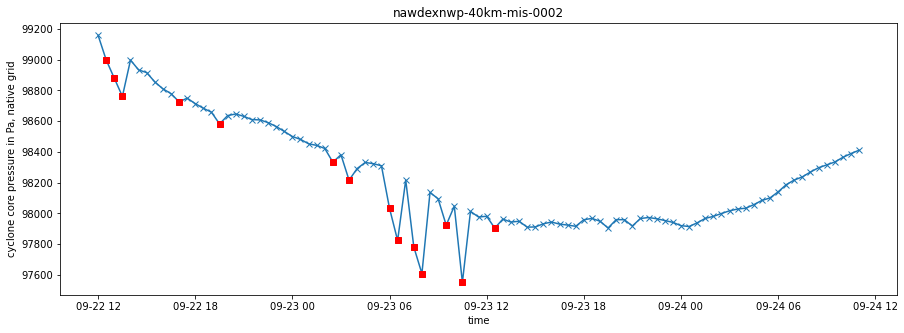

In [12]:
plt.figure(figsize=(15,5))

for ds in ds_list_native:
    if ds.attrs['sim']=='nawdexnwp-40km-mis-0002':
        plt.plot(ds['time'],ds['pres_msl_min'],'-x')
        plt.plot(ds['time'][[1,2,3,10,15,29,31,36,37,39,40,43,45,49]], 
                 ds['pres_msl_min'][[1,2,3,10,15,29,31,36,37,39,40,43,45,49]],'rs')
plt.title('nawdexnwp-40km-mis-0002')
plt.xlabel('time')
plt.ylabel('cyclone core pressure in Pa, native grid')

## Plot the diagnosed cyclone pressure and cyclone location over time

In [13]:
def plot_timeseries(ds_list, var):
    plt.figure(figsize=(20,5))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    ax1.set_title('1-moment microphysics, cyclone core pressure')
    ax2.set_title('2-moment microphysics, cyclone core pressure')
    ax1.set_ylabel(var)
    
    for ds in ds_list:
        sim = ds.attrs['sim']
        res = simdict[sim]['res']
        color = colordict[res]
        mphys = simdict[sim]['mphys']
        conv = simdict[sim]['conv']
        line = '-'
        if conv == 0: line='--'
        if mphys==1: ax1.plot(ds.time, ds[var], color=color, linestyle=line)
        if mphys==2: ax2.plot(ds.time, ds[var], color=color, linestyle=line)

Cyclone pressure

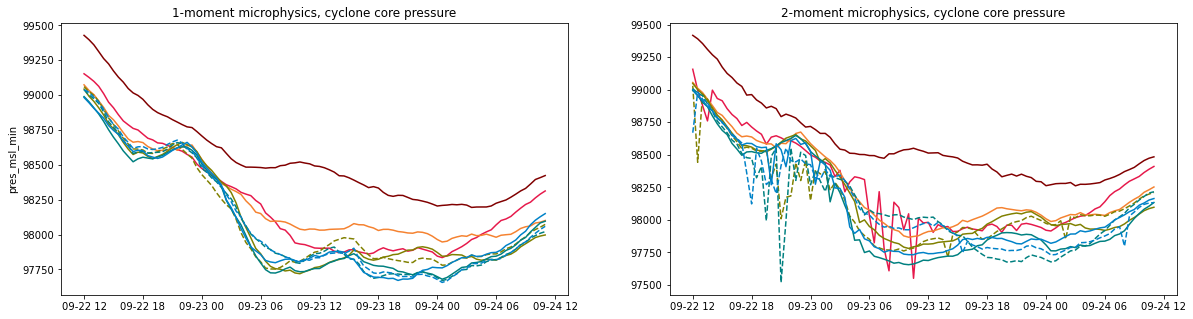

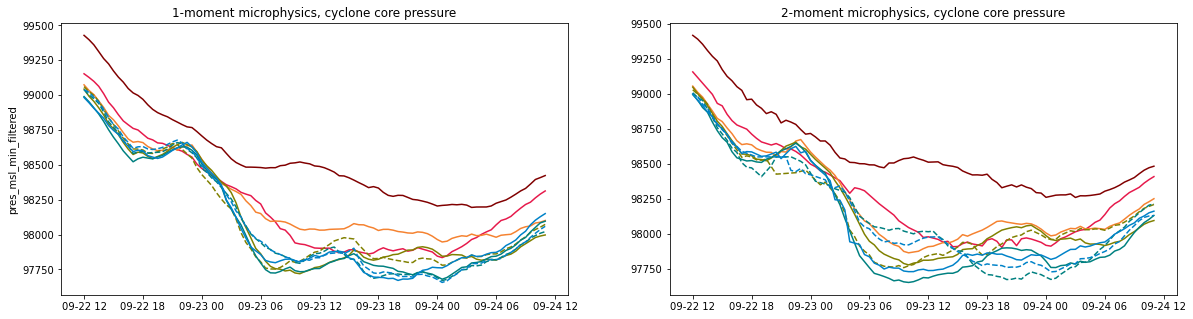

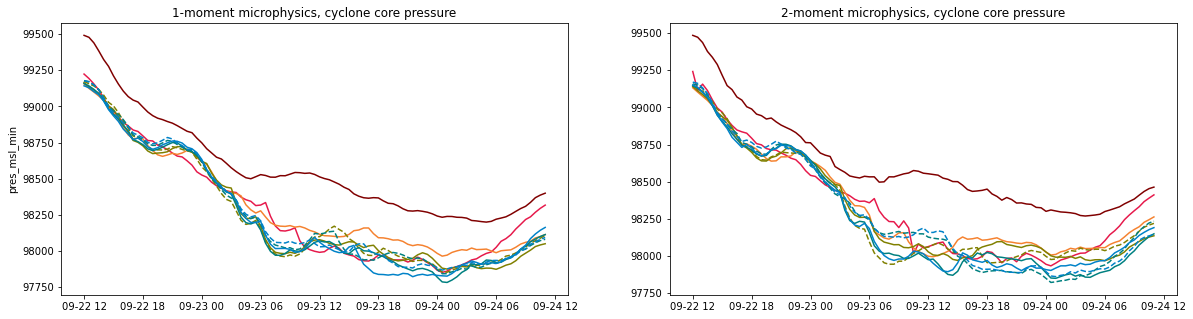

In [14]:
plot_timeseries(ds_list_native, 'pres_msl_min')
plot_timeseries(ds_list_native, 'pres_msl_min_filtered')
plot_timeseries(ds_list_remap,  'pres_msl_min')

Cyclone latitude

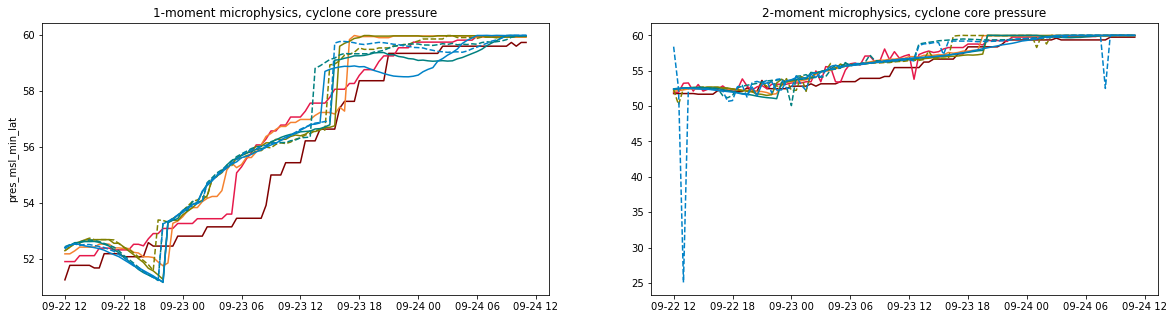

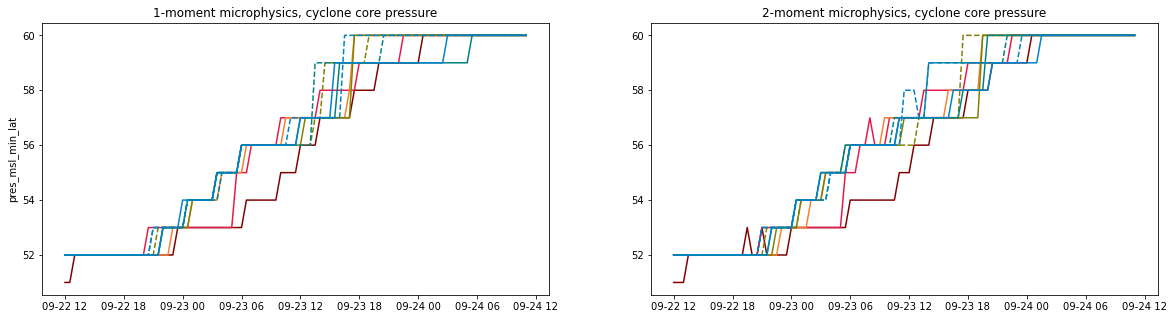

In [15]:
plot_timeseries(ds_list_native, 'pres_msl_min_lat')
plot_timeseries(ds_list_remap,  'pres_msl_min_lat')

Cyclone longitude

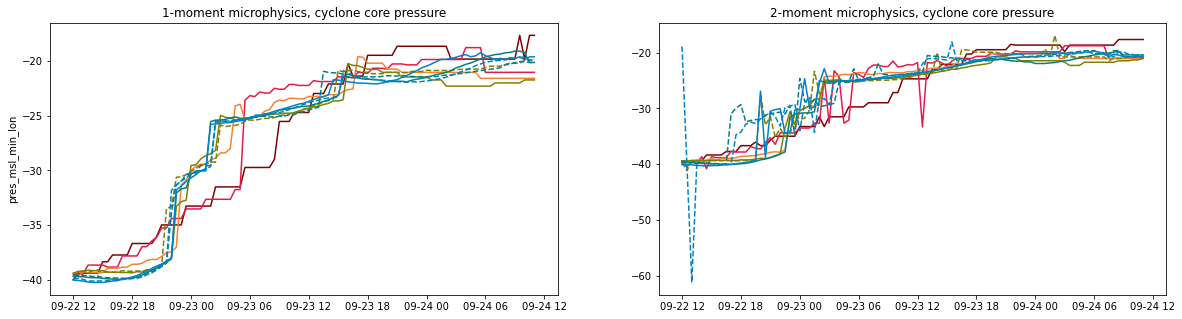

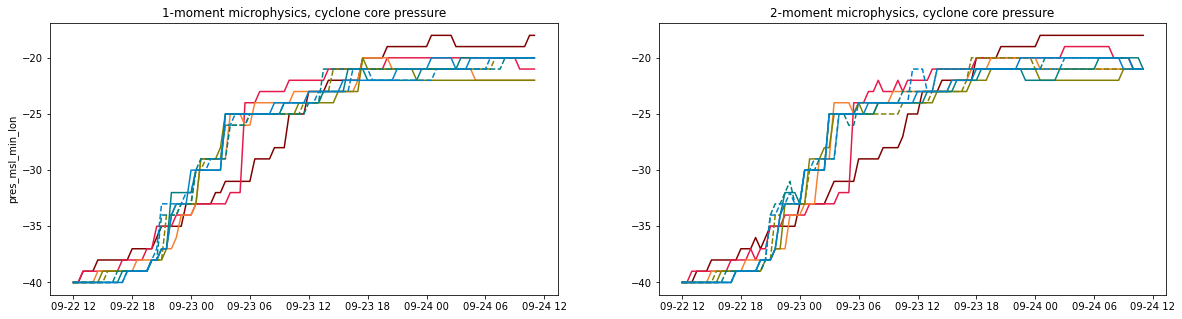

In [16]:
plot_timeseries(ds_list_native, 'pres_msl_min_lon')
plot_timeseries(ds_list_remap,  'pres_msl_min_lon')

For illustration, also plot cyclone pressure found on native and interpolated grid, as well as filtered native cyclone pressure for each simulation individually.

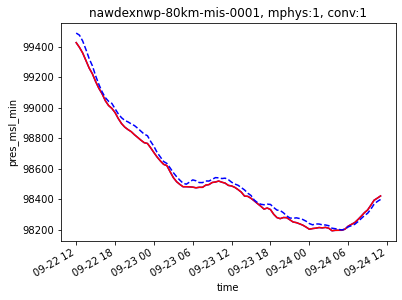

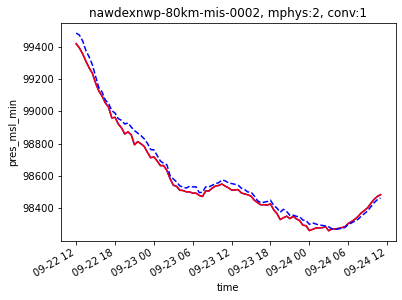

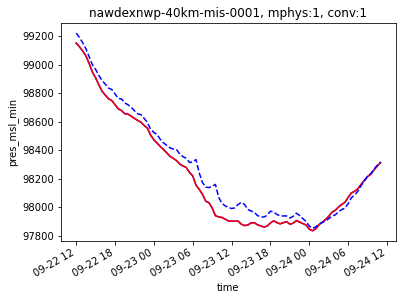

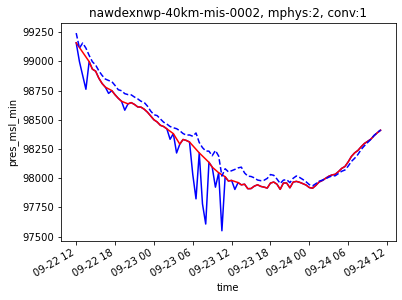

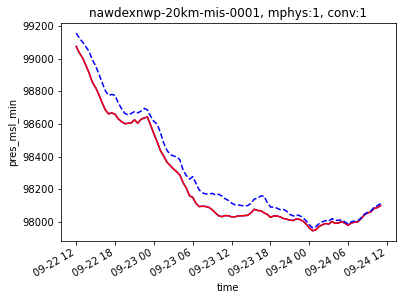

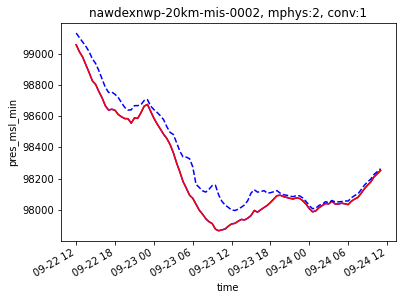

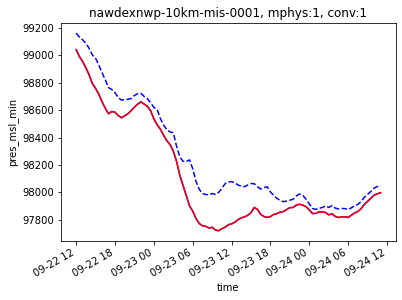

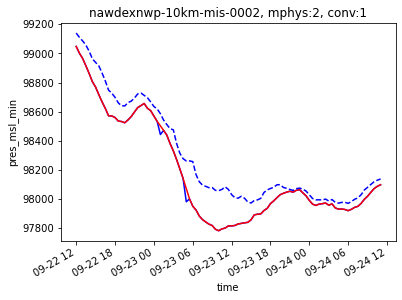

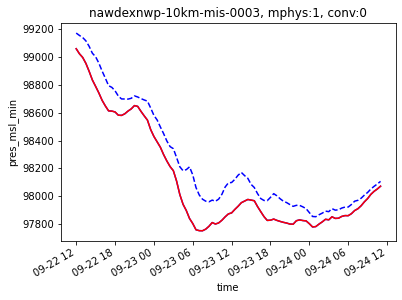

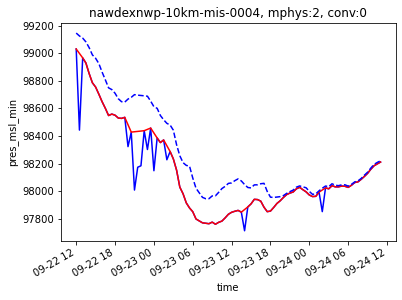

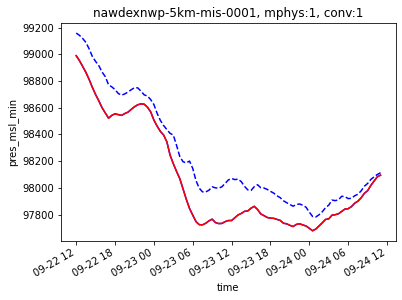

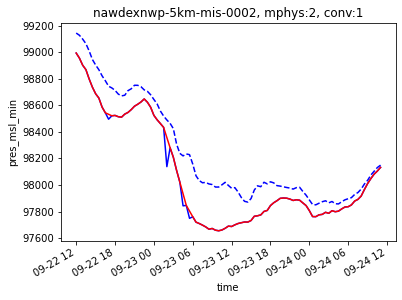

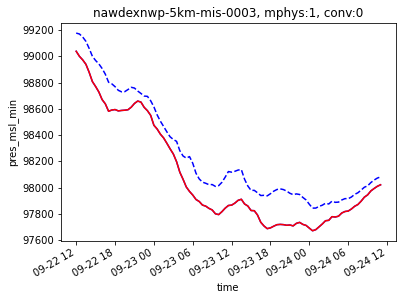

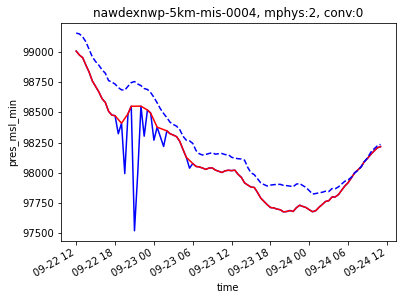

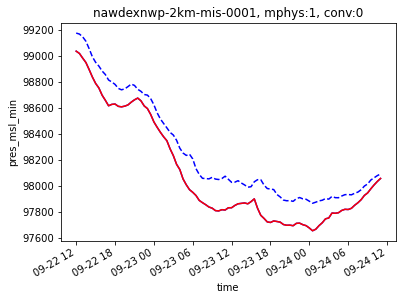

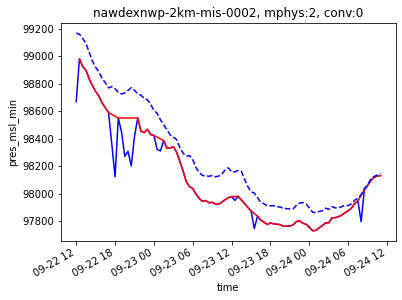

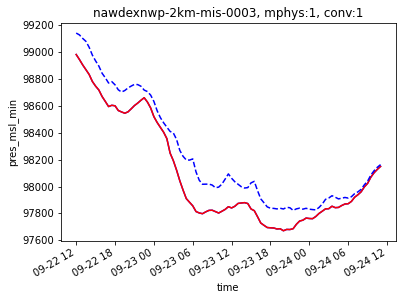

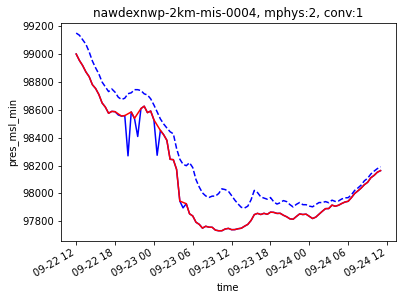

In [17]:
for i in range(nsim):
    sim = ds_list_native[i].attrs['sim']
    mphys = simdict[sim]['mphys']
    conv = simdict[sim]['conv']
    plt.figure(figsize=(6,4))
    ds_list_native[i]['pres_msl_min'].plot(color='b', linestyle='-')
    ds_list_native[i]['pres_msl_min_filtered'].plot(color='r', linestyle='-')
    ds_list_remap[i]['pres_msl_min'].plot(color='b', linestyle='--')
    plt.title(sim+', mphys:'+str(mphys)+', conv:'+str(conv))

## Calculate cyclone deepening between 22 Sep 12UTC and 23 Sep 09UTC

In [18]:
dp_native = np.zeros(nsim)
dp_remap  = np.zeros(nsim)

for i in range(nsim):
    dp_native[i] = ( ds_list_native[i]['pres_msl_min_filtered'].sel(time='2016-09-22T15:00') - 
                     ds_list_native[i]['pres_msl_min_filtered'].sel(time='2016-09-23T09:00') )
    dp_remap[i]  = ( ds_list_remap[i]['pres_msl_min'].sel(time='2016-09-22T15:00') - 
                     ds_list_remap[i]['pres_msl_min'].sel(time='2016-09-23T09:00') )

Text(0, 0.5, 'remapped grid in Pa')

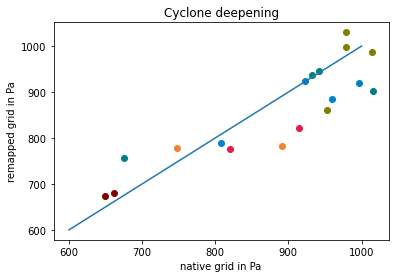

In [19]:
for i in range(nsim):
    sim = ds_list_native[i].attrs['sim']
    res = simdict[sim]['res']
    color = colordict[res]
    plt.plot(dp_native[i],dp_remap[i], 'o', color=color)
plt.plot([600,1000], [600,1000])
plt.title('Cyclone deepening')
plt.xlabel('native grid in Pa'); plt.ylabel('remapped grid in Pa')

## Save the filtered native-grid MSLP to disk

In [20]:
path = '/mnt/lustre01/pf/b/b380459/wcb-vladiana/'
for i in range(nsim):
    ds = ds_list_native[i]
    ds['pres_msl_min_filtered'].to_netcdf(path+'/'+ds.attrs['sim']+'_vladiana_cyclonepressure.nc')
    del ds    

## Shut down dask client

In [21]:
client.close()